# Example: equation of state (EOS) for CO$_2$

In [14]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 6
pd.options.display.max_columns = None
pd.options.display.width = 100
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import MDAnalysis as mda
from MDAnalysis import transformations
import nglview as nv

from scipy.ndimage import gaussian_filter

## initial configuration

### create intial configuraiton

* ```co2.zmat``` and ```co2.ff``` contains the information for EMP2 CO$_2$.
* using ```fftool``` and ```packmol``` to generate the intial simulaiton box.
* in this example, two systems are built
    * a dense system for expansion simulation: there are 500 CO$_2$ molecules in a $2.5\times2.5\times2.5$ nm$^3$ box
    * a dilute system for compression simulation: there are 250 CO$_2$ molecules in a $24\times24\times24$ nm$^3$ box

In [15]:
#dilute system
co2_num = 250; lx=ly=lz=240
#dense system
co2_num = 500; lx=ly=lz=25

In [16]:
%%capture
#capture magic command can hide the output of a cell
if 1:
    ! fftool $co2_num co2.zmat -t 2.5 -b $lx,$ly,$lz -c -p xyz
    ! packmol < pack.inp
    ! fftool $co2_num co2.zmat -t 2.5 -b $lx,$ly,$lz -c -p xyz -l

### visulize the inital configuration

In [17]:
u = mda.Universe('simbox.xyz')
view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_representation(repr_type='ball+stick',radius='0.5')
view.camera = 'orthographic'
view

NGLWidget()

<img src="./images/195372c1-b5e1-495c-aed8-047ba22032c1.png">

## run simulaitons
* we performed simulaitons at the temperature $T=280$ K.
* run expansion MD simulaiton using ```input_expansion.lmp``` and corresponding ```data.lmp```.
* run compression MD simulaiton using ```input_compression.lmp``` and corresponding ```data.lmp```.
* the expansion/compression simulation will be carried out as following: 
    * i) equilibrate the dense (dilute) system at a high (low) pressure $P=100$ atm ($P=1$ atm) for $0.5$ ns; 
    * ii) expand (compress) the dense (dilute) system to $P=1$ atm ($P=100$ atm) in $10$ ns.
* note that in the compression simulation, we use ```kspace ewald``` (which is less efficent than ```kspace pppm```) to make the simulation stable.

In [5]:
mypress_min=1
mypress_max=100
myprss_rate = (mypress_max-mypress_min)/10 # 10ns

## data analysis and visulization

### thermo. information

* here we show the change of thermo. information during the expsnion simulation

In [6]:
filename = 'result_thermo_expansion.log'
data = pd.read_csv(filename,sep='\s+',comment='#')
data['time'] -= data.loc[0,'time']
display(data)

,step,time,temp,atoms,pxx,pyy,pzz,lx,ly,lz,density
0,0,0,272.125780,1500,1500.143965,1676.930811,1258.222397,32.041697,32.041697,32.041697,1.110744
1,1000,1000,276.371296,1500,26.838183,-44.977071,-173.673986,32.210787,32.210787,32.210787,1.093343
2,2000,2000,289.328580,1500,114.347523,920.002757,645.326632,31.651125,31.651125,31.651125,1.152373
...,...,...,...,...,...,...,...,...,...,...,...
9998,9998000,9998000,263.453731,1500,2.947716,4.753438,0.800987,182.055943,182.055943,182.055943,0.006055
9999,9999000,9999000,275.340866,1500,0.636622,1.625135,0.560294,180.562733,180.562733,180.562733,0.006207
10000,10000000,10000000,279.383995,1500,1.287770,1.032092,-1.179455,175.543680,175.543680,175.543680,0.006755


#### temperature

average temp: 280.126 +- 6.828


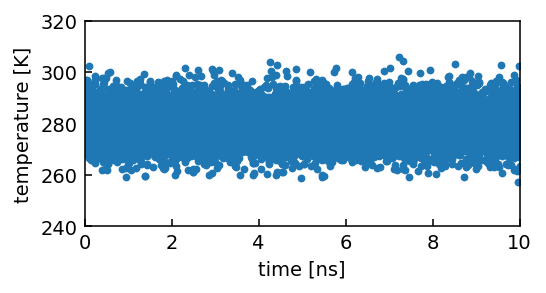

In [7]:
fig = plt.figure(figsize=(4,2.2), dpi=140);
ax = fig.add_subplot(111);

filename = 'result_thermo_expansion.log'
data = pd.read_csv(filename,sep='\s+',comment='#')
data['time'] -= data.loc[0,'time']
x = data['time']/1e6 # fs to ns
y = data['temp']
ax.plot(x,y,'.');
print('average temp: %.3f +- %.3f' %(np.mean(y.values),np.std(y.values)))

ax.set_xlabel('time [ns]');
ax.set_ylabel('temperature [K]');
ax.set_xlim(0,10);
ax.set_ylim(240,320);
ax.tick_params(direction='in')

plt.tight_layout()
plt.show()        

#### pressure changes
* compare with the linear change we set during the simulation

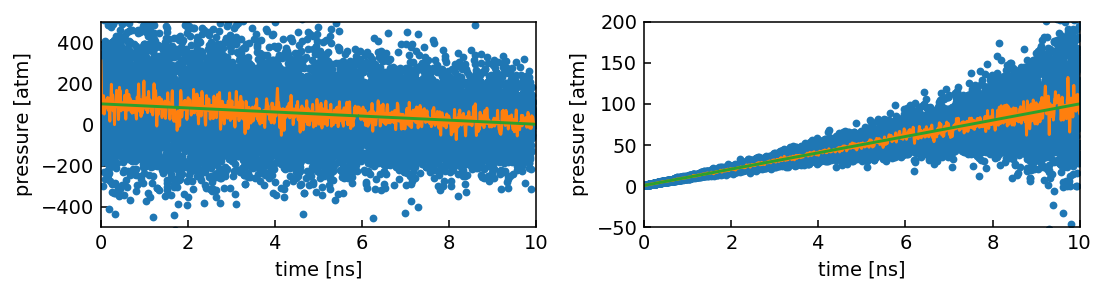

In [8]:
fig = plt.figure(figsize=(8,2.2), dpi=140);
ax = fig.add_subplot(121);

filename = 'result_thermo_expansion.log'
data = pd.read_csv(filename,sep='\s+',comment='#')
data['time'] -= data.loc[0,'time']
x = data['time']/1e6
y = (data['pxx']+data['pyy']+data['pzz'])/3
ax.plot(x,y,'.');
ysmooth = gaussian_filter(y.values,sigma=6)
ax.plot(x,ysmooth,'-');

y = mypress_max-myprss_rate*x.values
ax.plot(x,y,'-');

ax.set_xlabel('time [ns]');
ax.set_ylabel('pressure [atm]');
ax.set_xlim(0,10);
ax.set_ylim(-500,500);
ax.tick_params(direction='in')

ax = fig.add_subplot(122);

filename = 'result_thermo_compression.log'
data = pd.read_csv(filename,sep='\s+',comment='#')
data['time'] -= data.loc[0,'time']
x = data['time']/1e6
y = (data['pxx']+data['pyy']+data['pzz'])/3
ax.plot(x,y,'.');
ysmooth = gaussian_filter(y.values,sigma=6)
ax.plot(x,ysmooth,'-');

y = mypress_min+myprss_rate*x.values
ax.plot(x,y,'-');

ax.set_xlabel('time [ns]');
ax.set_ylabel('pressure [atm]');
ax.set_xlim(0,10);
ax.set_ylim(-50,200);
ax.tick_params(direction='in')

plt.tight_layout()
plt.show()        

### pressure vs. density (EOS)

* for better visulization, here we use the pressure calcualted based on the time and the changing rate of the pressure.
* during the expansion simulation, the density decreases as we reduce the pressure. At $P\sim 2$ atm, a jump of density appears, indicating that the phase transition from the liquid to the vpaor occurs. This result corresponds to that CO$_2$ can experience the first-order liquid-to-vapor phase transition at the temperature below the critical value (which is $\sim 304$ K for CO$_2$).
* during the compression simulation, the density gradually increase as we rise the pressure. We did not observe vapor-to-liquid phase transition. This pahse transition should occur at higher pressure.

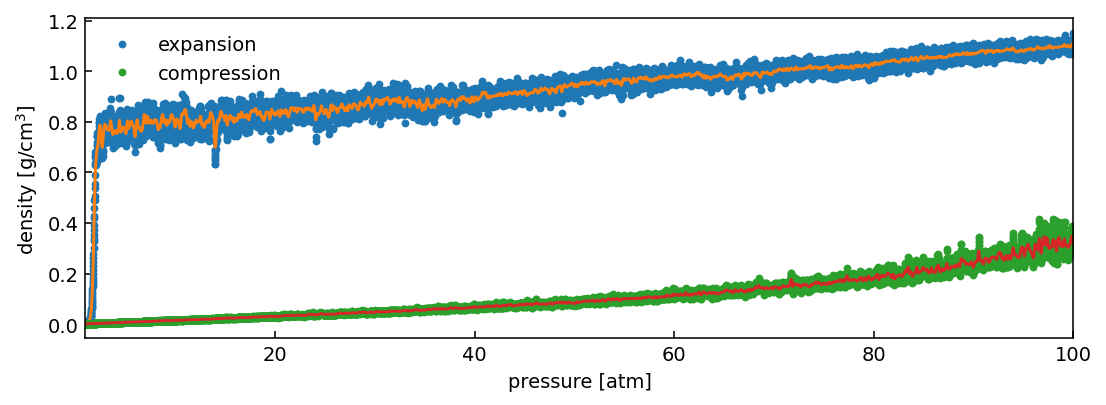

In [9]:
fig = plt.figure(figsize=(8,3), dpi=140);
ax = fig.add_subplot(111);

filename = 'result_thermo_expansion.log'
data = pd.read_csv(filename,sep='\s+',comment='#')
data['time'] -= data.loc[0,'time']

x = mypress_max-myprss_rate*data['time'].values*1e-6
y = data['density']
ax.plot(x,y,'.',label='expansion');
ysmooth = gaussian_filter(y.values,sigma=6)
ax.plot(x,ysmooth,'-');

filename = 'result_thermo_compression.log'
data = pd.read_csv(filename,sep='\s+',comment='#')
data['time'] -= data.loc[0,'time']

x = mypress_min+myprss_rate*data['time'].values*1e-6
y = data['density']
ax.plot(x,y,'.',label='compression');
ysmooth = gaussian_filter(y.values,sigma=6)
ax.plot(x,ysmooth,'-');

ax.set_xlabel('pressure [atm]');
ax.set_ylabel('density [g/cm$^3$]');
ax.set_xlim(1,100);
#ax.set_ylim(0,);
ax.tick_params(direction='in')
ax.patch.set_facecolor('None')

ax.legend(frameon=False)

plt.tight_layout()
plt.show()        

### EOS for CO$_2$ gas vs. EOS for ideal gas

* we compare the EOS obtained from the compression simulation and the EOS for ideal gas
* the EOS for ideal gas is given by 
  $$P=\rho k_BT$$
  with $P$ the press, $\rho$ the numbder density, $k_B$ the Bolztmann constant, $T$ the temperature and $T=280$ K in this example.
* the different between CO$_2$ and ideal gas is due to the interactions between CO$_2$.

In [10]:
kB = 1.380649e-23 #J/K
T = 280 #K
co2_mol_mass = 44.01 #g/mol
NA = 6.02214076e23

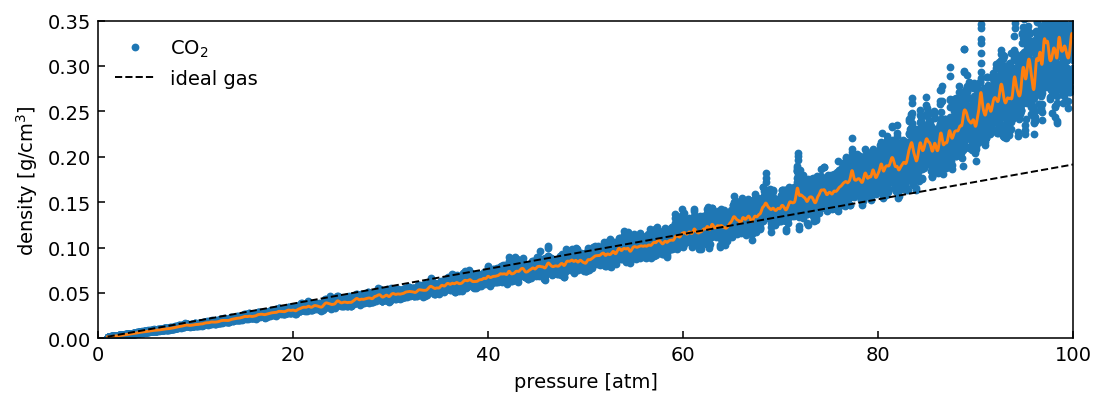

In [11]:
fig = plt.figure(figsize=(8,3), dpi=140);
ax = fig.add_subplot(111);

filename = 'result_thermo_compression.log'
data = pd.read_csv(filename,sep='\s+',comment='#')
data['time'] -= data.loc[0,'time']
x = mypress_min+myprss_rate*data['time'].values*1e-6
y = data['density']
ax.plot(x,y,'.',label=r'CO$_2$');
ysmooth = gaussian_filter(y.values,sigma=12)
ax.plot(x,ysmooth,'-');

# ideal gas
x = np.linspace(1,100,100)
y = x*101325/kB/T/NA*co2_mol_mass*1e-6 # to g/cm3
ax.plot(x,y,'k--',lw=1,label=r'ideal gas');

ax.set_xlabel('pressure [atm]');
ax.set_ylabel('density [g/cm$^3$]');
ax.set_xlim(0,100);
ax.set_ylim(0,0.35);
ax.tick_params(direction='in')
ax.patch.set_facecolor('None')

ax.legend(frameon=False)

plt.tight_layout()
plt.show()        

## visulize trajectory
* note that the simulation box may be not correctly shown in ```nglview```.
* we only save last 10 frames in the expansion trajectory here.
* we can observe the sudden liquid-to-vapor phase transition at a very low pressure during the expansion simulation.

In [19]:
directory = './'
u = mda.Universe(directory+'result_atoms.data', atom_style='id resid type charge x y z')

elements = []
for i in range(len(u.atoms)):
    if u.atoms[i].type in ['1']: 
        elements.append('O')
    elif u.atoms[i].type in ['2']:
        elements.append('C')
u.add_TopologyAttr('element',values=elements)

u.load_new(directory+"result_atoms_expansion.lammpstrj", format="LAMMPSDUMP",timeunit="fs")
workflow = [transformations.unwrap(u.atoms)]
u.trajectory.add_transformations(*workflow)

resnames = ['co2']*co2_num #numbder of co2 molecules
u.add_TopologyAttr('resnames',values=resnames)

In [20]:
view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_representation(repr_type='ball+stick',radius='0.5')
view.add_unitcell()
view.camera = 'orthographic'
view

NGLWidget(max_frame=9)

<img src="./images/11683d8c-18b6-459c-b670-cc2fe683fb70.png">

* we can save the trajectory to ```.xyz``` file and open it in VMD

In [14]:
if 0:
    with mda.Writer('result_atoms.xyz', len(u.atoms)) as w:
        for ts in u.trajectory:
            w.write(u)